## Import necessary packages

In [1]:
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from copy import deepcopy
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
from torch import nn
import random
import torch
import os

## Set hyperparameters and constant values

In [2]:
TRAIN_DIR = 'Training/'
TEST_DIR = 'Testing/'
IMG_SIZE = 224
TRAIN_BATCHSIZE = 200
EVAL_BATCHSIZE = 10
EPOCHS = 10
TRAIN_FRACTION = 0.8
TEST_FRACTION = 0.1
VALIDATION_FRACTION = 0.1
DATA_LABELS = {0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}

## Define function for plotting images in datasets

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_sample_images(dataset, num_samples_per_class=4):
    samples = defaultdict(list)
    
    # Loop through the dataset to collect samples
    for img, label in dataset:
        if len(samples[label]) < num_samples_per_class:
            samples[label].append(img)

    # Create a subplot grid to display the images
    num_classes = len(samples)
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 5 * num_classes))

    for i, (label, imgs) in enumerate(samples.items()):
        for j, img in enumerate(imgs):
            img_np = img.permute(1, 2, 0).cpu().numpy() if img.dim() == 3 else img.cpu().numpy()
            axes[i, j].imshow(img_np, cmap='gray')
            axes[i, j].axis('off')
            
        axes[i, 0].set_title(DATA_LABELS[label])

    plt.show()


## Instantiate dataset classes

In [4]:
def get_dataset_info(data_dir):
    image_paths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)
                labels.append(class_name)
    return image_paths, labels

train_image_paths, train_labels = get_dataset_info(TRAIN_DIR)
test_image_paths, test_labels = get_dataset_info(TEST_DIR)

In [5]:
label_to_int = {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, img_size=(224, 224), is_training=False):
        self.image_paths = image_paths
        self.labels = labels
        self.img_size = img_size
        self.is_training = is_training
        self.transforms_dict = self._get_transforms()

    def _get_transforms(self):
        transforms_dict = {}
        
        # Base transformation that applies to all images
        common_transforms = [
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
        transforms_dict['base'] = transforms.Compose(common_transforms)
        
        # Transformations that are only applied if the model is training
        if self.is_training:
            # Rotation
            for angle in [45, 90, 120, 180, 270, 300, 330]:
                transforms_dict[f'rot_{angle}'] = transforms.RandomRotation(angle)
            
            # Random Horizontal and Vertical Flip
            transforms_dict['hflip'] = transforms.RandomHorizontalFlip(p=0.5)
            transforms_dict['vflip'] = transforms.RandomVerticalFlip(p=0.5)
            
            # Random Brightness and Contrast
            transforms_dict['brightness_contrast'] = transforms.ColorJitter(brightness=0.2, contrast=0.4)
            
            # Random Affine
            transforms_dict['affine'] = transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))
        
        return transforms_dict


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Convert label to integer
        label = label_to_int[label]
        
        image = Image.open(image_path).convert('RGB')
        
        image = self.transforms_dict['base'](image)

        if self.is_training:
            angle_key = random.choice(list(self.transforms_dict.keys())[1:]) 
            image = self.transforms_dict[angle_key](image)

        return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

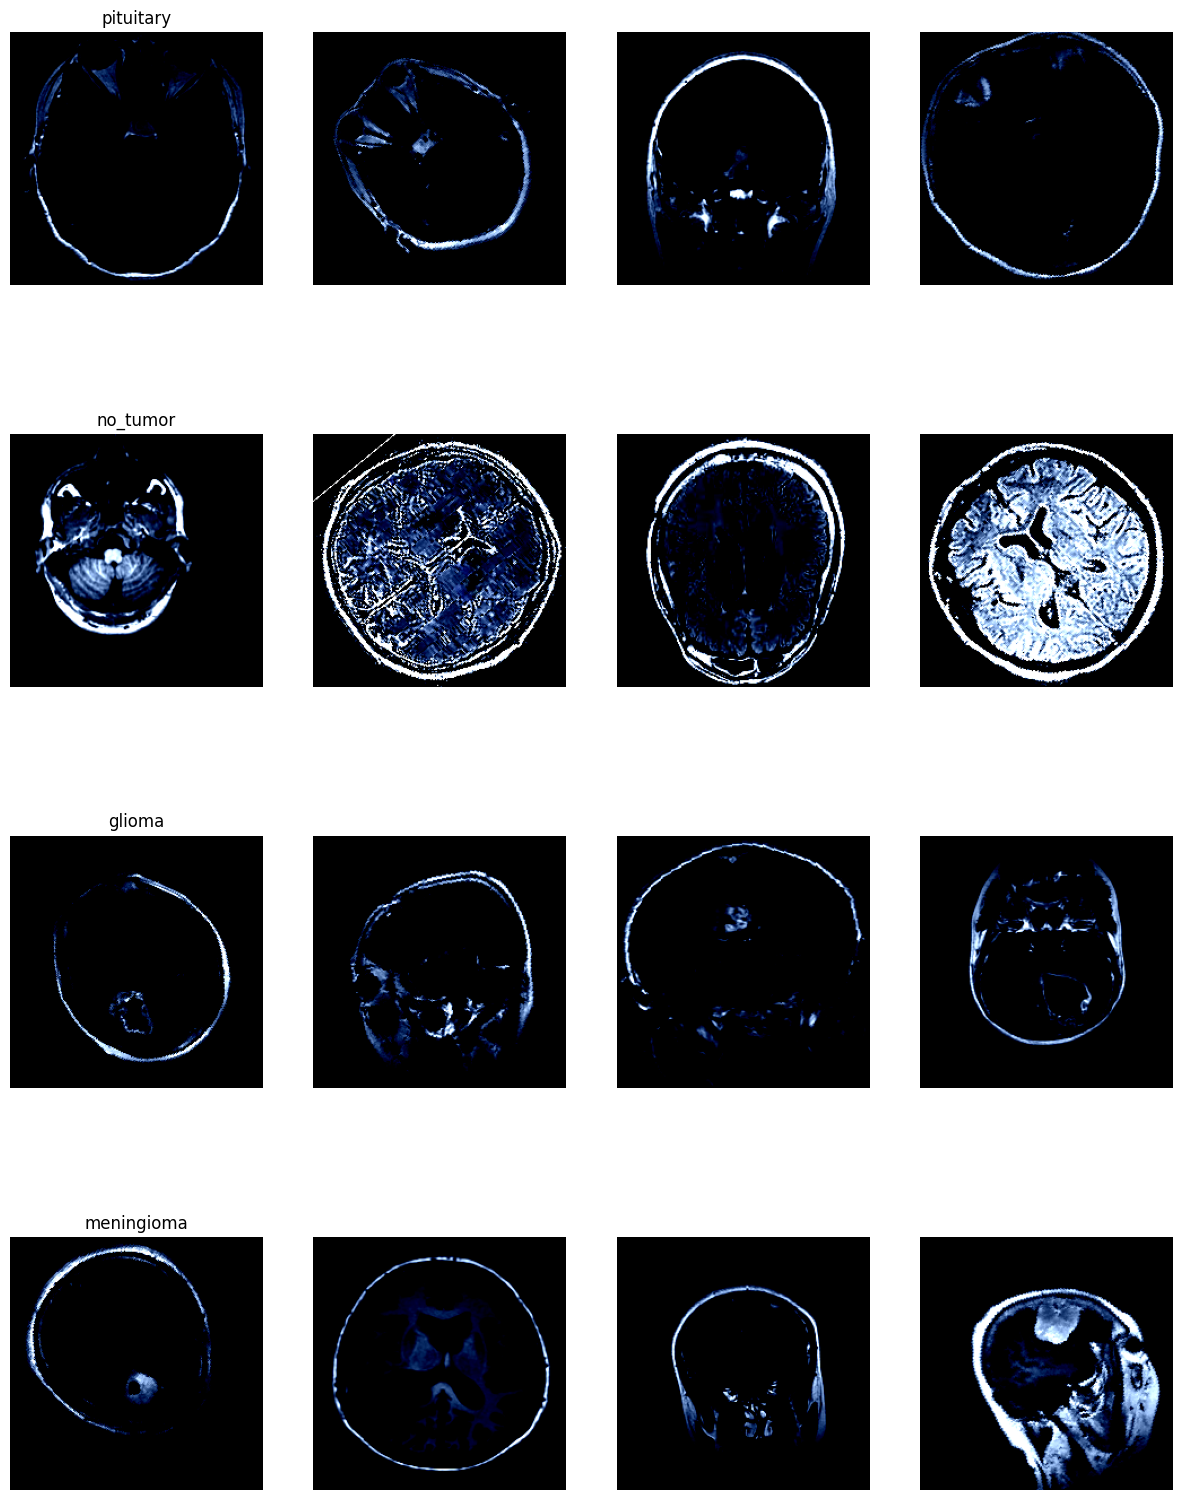

In [6]:
train_dataset = BrainTumorDataset(image_paths=train_image_paths, labels=train_labels, is_training=True)
test_dataset_full = BrainTumorDataset(image_paths=test_image_paths, labels=test_labels, is_training=False)

plot_sample_images(train_dataset)

## Create testing and validation datasets

### Split the testing data into testing and validation sets randomly

In [7]:
total_test_samples = len(test_dataset_full)
TEST_FRACTION = int(total_test_samples * 0.7)  # 70% for testing
VALIDATION_FRACTION = total_test_samples - TEST_FRACTION  # remaining for validation

test_dataset, validation_dataset = torch.utils.data.random_split(
    test_dataset_full,
    [TEST_FRACTION, VALIDATION_FRACTION]
)

In [8]:
print(f"Number of elements in training set: {len(train_dataset)}")
print(f"Number of elements in testing set: {len(test_dataset)}")
print(f"Number of elements in validation set: {len(validation_dataset)}")

Number of elements in training set: 12767
Number of elements in testing set: 1192
Number of elements in validation set: 512


In [9]:
print(f"Number of augmented elements in training set: {len(train_dataset) * 8}")
print(f"Number of augmented elements in testing set: {len(test_dataset) * 8}")
print(f"Number of augmented elements in validation set: {len(validation_dataset) * 8}")

Number of augmented elements in training set: 102136
Number of augmented elements in testing set: 9536
Number of augmented elements in validation set: 4096


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {device}')

Running on cpu


## Create data loaders for trainig, testing, and validation

In [11]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAIN_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

validation_loader = DataLoader(
    validation_dataset, 
    batch_size=EVAL_BATCHSIZE,
    pin_memory=True,
    shuffle=True
)

In [12]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [13]:
net = resnet50()

for param in net.parameters():
    param.requires_grad = True

n_inputs = net.fc.in_features

net.fc = nn.Sequential(nn.Linear(
    n_inputs, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 2048),
    nn.SELU(),
    nn.Dropout(p=0.4),
    nn.Linear(2048, 4),
)

for name, child in net.named_children():
  for name2, params in child.named_parameters():
    params.requires_grad = True

net.to(device)

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
criterion = nn.CrossEntropyLoss()
error_minimizer = torch.optim.SGD(net.parameters(), momentum=0.9, lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(error_minimizer, step_size=7, gamma=0.1)

net_final = deepcopy(net)

## Training loop

In [15]:
best_validation_accuracy = 0.
best_training_accuracy = 0.
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    net.train()
    
    print(f"# Epoch {epoch + 1}:")
    
    total_train_examples = 0
    num_correct_train = 0
    
    for batch_index, (inputs, targets) in enumerate(train_loader):
        print(f"Batch {batch_index + 1}/{len(train_loader)}")

        inputs, targets = inputs.to(device), targets.to(device)

        error_minimizer.zero_grad()
        
        predictions = net(inputs)
        
        loss = criterion(predictions, targets)
        print(f"Batch training loss: {loss.item()}")
        
        loss.backward()
        error_minimizer.step()
        scheduler.step()
        
        _, predicted_class = predictions.max(1)
        total_train_examples += predicted_class.size(0)
        num_correct_train += predicted_class.eq(targets).sum().item()

        # Calculate and print batch-level training accuracy
        batch_train_acc = num_correct_train / total_train_examples
        print(f"Batch training accuracy: {batch_train_acc}")

    train_acc = num_correct_train / total_train_examples
    print(f"Training accuracy: {train_acc}")
    train_accs.append(train_acc)
    
    if train_acc > best_training_accuracy:
        best_training_accuracy = train_acc
        print(f"Training accuracy improved to {best_training_accuracy}")

    total_val_examples = 0
    num_correct_val = 0
    
    net.eval()

    with torch.no_grad():
        for batch_index, (inputs, targets) in enumerate(validation_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            predictions = net(inputs)
            _, predicted_class = predictions.max(1)
            
            total_val_examples += predicted_class.size(0)
            num_correct_val += predicted_class.eq(targets).sum().item()
            
            batch_val_acc = num_correct_val / total_val_examples
            print(f"Batch validation accuracy: {batch_val_acc}")

    val_acc = num_correct_val / total_val_examples
    print(f"Validation accuracy: {val_acc}")
    val_accs.append(val_acc)
    
    if val_acc > best_validation_accuracy:
        print(f"Validation accuracy improved from {best_validation_accuracy} to {val_acc}")
        best_validation_accuracy = val_acc
        print("Validation accuracy was improved. Saving new model.")
        net_final = deepcopy(net)

# Epoch 1:
Batch 1/64
Batch training loss: 1.4324380159378052
Batch training accuracy: 0.255
Batch 2/64
Batch training loss: 1.4218298196792603
Batch training accuracy: 0.245
Batch 3/64
Batch training loss: 1.4361178874969482
Batch training accuracy: 0.24166666666666667
Batch 4/64
Batch training loss: 1.4069706201553345
Batch training accuracy: 0.255
Batch 5/64
Batch training loss: 1.4038140773773193
Batch training accuracy: 0.261
Batch 6/64
Batch training loss: 1.3857765197753906
Batch training accuracy: 0.2658333333333333
Batch 7/64
Batch training loss: 1.3884191513061523
Batch training accuracy: 0.265
Batch 8/64
Batch training loss: 1.372103214263916
Batch training accuracy: 0.27
Batch 9/64
Batch training loss: 1.3950257301330566
Batch training accuracy: 0.26555555555555554
Batch 10/64
Batch training loss: 1.3594812154769897
Batch training accuracy: 0.268
Batch 11/64
Batch training loss: 1.3593825101852417
Batch training accuracy: 0.2759090909090909
Batch 12/64
Batch training loss: 

## Testing loop

In [ ]:
net.eval()

total_test_examples = 0
num_correct_test = 0

with torch.no_grad():
    for batch_index, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        predictions = net(inputs)
        _, predicted_class = predictions.max(1)
        
        total_test_examples += predicted_class.size(0)
        num_correct_test += predicted_class.eq(targets).sum().item()

test_acc = num_correct_test / total_test_examples
print(f"Test accuracy: {test_acc}")


## Plot results

In [ ]:
import matplotlib.pyplot as plt

epochs_list = list(range(EPOCHS))

plt.figure()
plt.plot(epochs_list, train_accs, 'b-', label='training set accuracy')
plt.plot(epochs_list, val_accs, 'r-', label='validation set accuracy')
plt.xlabel('epoch')
plt.ylabel('prediction accuracy')
plt.ylim(0.5, 1)
plt.title('Classifier training evolution:\nprediction accuracy over time')
plt.legend()
plt.show()